In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from models.resnet1d import resnet18
from torch.utils.data import DataLoader
from models.Decoder_CNN import ConvDecoder
from MSGDataset import MsgDataset
import torch.distributions as dist
import os
import matplotlib.pyplot as plt

In [2]:
encoder = resnet18(num_input_channels=5, num_classes=2, return_feature=True).cuda()
decoder = ConvDecoder().cuda()
normal_data = MsgDataset(patient=1, mode='train', split='train', label=0, norm=True)
recon_state_dict = torch.load('/home/pg34/code/seizure/recon_5chn_best.pt', map_location='cuda')
encoder.load_state_dict(recon_state_dict['encoder'])   
decoder.load_state_dict(recon_state_dict['decoder'])
encoder.eval();
decoder.eval();

In [3]:
x, label = normal_data[3]
x = x.unsqueeze(0).cuda()
x_e, _ = encoder(x)
x_hat = decoder(x_e)

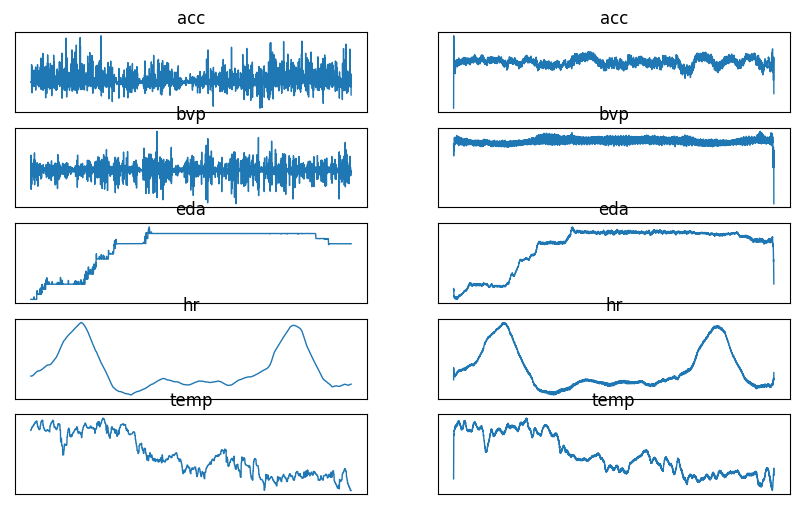

In [7]:
x_i = x.squeeze(0).cpu().numpy()
x_o = x_hat.squeeze(0).detach().cpu().numpy()
channels = ['acc', 'bvp', 'eda', 'hr', 'temp']
k = 0
fig, ax = plt.subplots(5, 2, figsize=(10,6))
for i in range(5):
    ax[i,0].plot(x_i[i,:], linewidth=1)
    ax[i,0].set_title(channels[i], fontsize=12)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].plot(x_o[i,:], linewidth=1)
    ax[i,1].set_title(channels[i], fontsize=12)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    
# fig, ax = plt.subplots(1, 2, figsize=(10,2))
# for i in range(1):
#     ax[0].plot(x_i[i,:], linewidth=1)
#     ax[0].set_title(channels[i])

#     ax[1].plot(x_o[i,:], linewidth=0.5)
#     ax[1].set_title(channels[i])
# plt.show()

In [1]:
import os
import numpy as np
base_path = '/rdf/data/epilepsy/minutes'
label_path = os.path.join(base_path, '10min_label.npy')
labels = np.load(label_path)
labels = np.round(labels).astype(np.int64)

In [12]:
unique_values, value_counts = np.unique(labels, return_counts=True)
print(unique_values)
print(value_counts)

[-1.  0.  1.]
[  532 24109    55]


In [11]:
np.round(labels).astype(np.int64)

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
import pandas as pd

# Split data_norm into chunks of size n_seizure*2
data = pd.read_csv('/rdf/data/msg2022/train/train_val_split.csv')
data = data[(data['patient']==1904)]
patient_scores = pd.read_csv(f'/home/pg34/code/seizure/selective_sampling/logs/stats/p3_losses.csv')
data = data.merge(patient_scores, on='filepath')
data_seizure = data[data['label'] == 1]
n_seizure = len(data_seizure)
data_norm = data[data['label'] == 0]
data_norm = data_norm.sort_values('MSE', ascending=False)
chunks = [data_norm.iloc[i:i+(n_seizure*2)] for i in range(0, len(data_norm), n_seizure*2)]

# Append data_seizure to each chunk and shuffle
for i in range(len(chunks)):
    chunks[i] = chunks[i].append(data_seizure).sample(frac=1).reset_index(drop=True)
    # chunks[i] = pd.concat(chunks[i], data_seizure).sample(frac=1).reset_index(drop=True)


# Concatenate the shuffled chunks into a single dataframe
result_df = pd.concat(chunks).reset_index(drop=True)
result_df

/tmp/ipykernel_1165740/2634726984.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  chunks[i] = pd.concat(chunks[i], data_seizure).sample(frac=1).reset_index(drop=True)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"